In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

#Load the data
train_df = pd.read_csv('earnings_train.csv')
test_df = pd.read_csv('earnings_test_features.csv')

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("\nFirst few rows:")
print(train_df.head())

Training data shape: (20705, 11)
Test data shape: (6902, 10)

First few rows:
          DISTRICT_TYPE       DISTRICT_NAME  DISTRICT_CODE ACADEMIC_YEAR  \
0       School District      Duarte Unified      1964469.0     2018-2019   
1       School District    Coronado Unified      3768031.0     2018-2019   
2       School District      Gilroy Unified      4369484.0     2018-2019   
3       School District     Pleasant Valley      5672553.0     2018-2019   
4  Legislative District  Senate District 15            NaN     2018-2019   

     DEMO_CATEGORY                       STUDENT_POPULATION  \
0             Race                            None Reported   
1             Race                            None Reported   
2             Race                Black or African American   
3  Homeless Status  Did Not Experience Homelessness in K-12   
4             Race         American Indian or Alaska Native   

                         AWARD_CATEGORY  WAGE_YEAR1  WAGE_YEAR2  WAGE_YEAR3  \
0  Bach

In [ ]:

#-----DATA PREPROCESSING-----

#Separates target variable
X = train_df.drop('WAGE_YEAR4', axis=1)
y = train_df['WAGE_YEAR4']

#Checks for missing values
print("\nMissing values in training data:")
print(X.isnull().sum())

#Identifies categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\nCategorical columns: {categorical_cols}")
print(f"\nNumerical columns: {numerical_cols}")

#Handle missing values for numerical columns, fills with the median
for col in numerical_cols:
    if X[col].isnull().sum() > 0:
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)
        test_df[col].fillna(median_val, inplace=True)

#For categorical columns, fills with the mode
for col in categorical_cols:
    if X[col].isnull().sum() > 0:
        mode_val = X[col].mode()[0]
        X[col].fillna(mode_val, inplace=True)
        test_df[col].fillna(mode_val, inplace=True)

#Encodes the categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    label_encoders[col] = le

#Creates additional features if previous wage data exists
if 'WAGE_YEAR1' in X.columns and 'WAGE_YEAR2' in X.columns and 'WAGE_YEAR3' in X.columns:
    #Average wage trend
    X['avg_wage'] = (X['WAGE_YEAR1'] + X['WAGE_YEAR2'] + X['WAGE_YEAR3']) / 3
    test_df['avg_wage'] = (test_df['WAGE_YEAR1'] + test_df['WAGE_YEAR2'] + test_df['WAGE_YEAR3']) / 3

    #Wage growth rate
    X['wage_growth_1_2'] = X['WAGE_YEAR2'] - X['WAGE_YEAR1']
    X['wage_growth_2_3'] = X['WAGE_YEAR3'] - X['WAGE_YEAR2']
    test_df['wage_growth_1_2'] = test_df['WAGE_YEAR2'] - test_df['WAGE_YEAR1']
    test_df['wage_growth_2_3'] = test_df['WAGE_YEAR3'] - test_df['WAGE_YEAR2']


Missing values in training data:
DISTRICT_TYPE            0
DISTRICT_NAME            0
DISTRICT_CODE         2745
ACADEMIC_YEAR            0
DEMO_CATEGORY            0
STUDENT_POPULATION       0
AWARD_CATEGORY           0
WAGE_YEAR1               0
WAGE_YEAR2               0
WAGE_YEAR3               0
dtype: int64

Categorical columns: ['DISTRICT_TYPE', 'DISTRICT_NAME', 'ACADEMIC_YEAR', 'DEMO_CATEGORY', 'STUDENT_POPULATION', 'AWARD_CATEGORY']

Numerical columns: ['DISTRICT_CODE', 'WAGE_YEAR1', 'WAGE_YEAR2', 'WAGE_YEAR3']


In [ ]:
#-----TRAIN TEST SPLIT FOR VALIDATION-----

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

#-----MODEL TRAINING & COMPARISON-----


models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, min_samples_split=20, random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=10),
}

results = {}

print("MODEL COMPARISON")
for name, model in models.items():
    #Train the model
    model.fit(X_train, y_train)

    #Make predictions
    y_pred = model.predict(X_val)

    #Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    results[name] = {'RMSE': rmse, 'R2': r2}

    print(f"\n{name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.4f}")

#Find best model
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
print(f"BEST MODEL: {best_model_name}")
print(f"RMSE: {results[best_model_name]['RMSE']:.2f}")

MODEL COMPARISON

Linear Regression:
  RMSE: 2471.71
  R²: 0.9873

Decision Tree:
  RMSE: 2282.55
  R²: 0.9892

KNN:
  RMSE: 2981.57
  R²: 0.9815
BEST MODEL: Decision Tree
RMSE: 2282.55


In [ ]:

#-----TRAIN FINAL MODEL ON FULL DATA-----


#Retrain best model on full training data
final_model = models[best_model_name]
final_model.fit(X, y)

#Make predictions on test set
test_predictions = final_model.predict(test_df)


Top 10 Most Important Features:
               feature  importance
9           WAGE_YEAR3    0.995432
10            avg_wage    0.001315
12     wage_growth_2_3    0.000754
8           WAGE_YEAR2    0.000620
2        DISTRICT_CODE    0.000509
7           WAGE_YEAR1    0.000464
11     wage_growth_1_2    0.000461
1        DISTRICT_NAME    0.000256
6       AWARD_CATEGORY    0.000139
5   STUDENT_POPULATION    0.000037


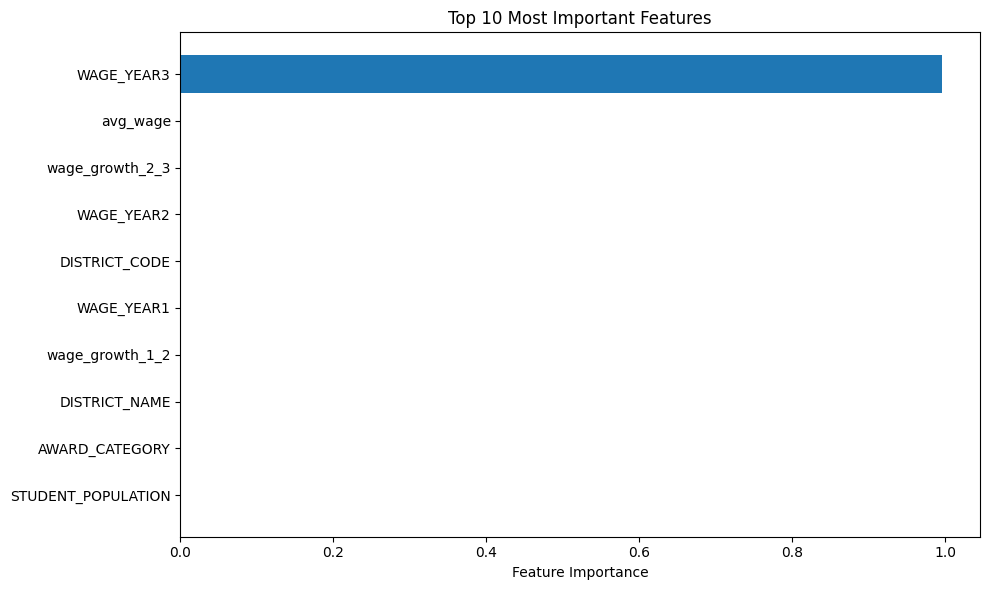

In [ ]:

#-----FEATURE IMPORTANCE-----


if hasattr(final_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': np.abs(final_model.coef_)
    }).sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

    #Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance.head(10)['feature'], feature_importance.head(10)['importance'])
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Top 10 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

elif hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

    #Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance.head(10)['feature'], feature_importance.head(10)['importance'])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


Predictions saved to 'preds.csv'
Number of predictions: 6902

Sample predictions:
     WAGE_YEAR4
0      0.000000
1  44692.791667
2      0.000000
3      0.000000
4  39538.368421
5      0.000000
6      0.000000
7  41728.965517
8      0.000000
9      0.000000

Prediction Statistics:
Mean predicted wage: $8718.02
Median predicted wage: $0.00
Min predicted wage: $0.00
Max predicted wage: $124653.25


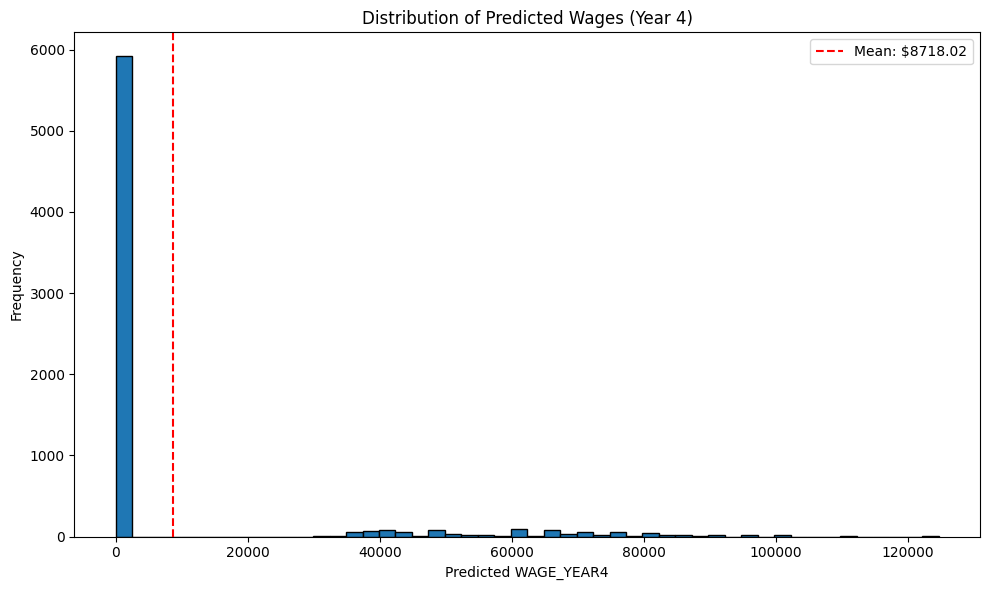

In [ ]:
#-----PREDICTION ANALYSIS-----

#Create predictions dataframe
predictions_df = pd.DataFrame({'WAGE_YEAR4': test_predictions})

#Save to CSV
predictions_df.to_csv('preds.csv', index=False, header=False)

print("\nPredictions saved to 'preds.csv'")
print(f"Number of predictions: {len(test_predictions)}")
print(f"\nSample predictions:")
print(predictions_df.head(10))


print("\nPrediction Statistics:")
print(f"Mean predicted wage: ${test_predictions.mean():.2f}")
print(f"Median predicted wage: ${np.median(test_predictions):.2f}")
print(f"Min predicted wage: ${test_predictions.min():.2f}")
print(f"Max predicted wage: ${test_predictions.max():.2f}")

#Plot prediction distribution
plt.figure(figsize=(10, 6))
plt.hist(test_predictions, bins=50, edgecolor='black')
plt.xlabel('Predicted WAGE_YEAR4')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Wages (Year 4)')
plt.axvline(test_predictions.mean(), color='red', linestyle='--', label=f'Mean: ${test_predictions.mean():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

***Part 3 - Reflection***

For Part 1, exploring the data taught me a lot about its quality and structure. I noticed that many of the wage entries were zero, which likely indicated missing or unreported data rather than actual $0 salaries. The categorical columns, like district type and award category, had only a few unique values, which made them easier to encode for modeling. Visualizing the data helped me see important trends, such as how wages generally increased over the four years after graduation and how degree type seemed to have a strong effect on earnings.

During Part 2, building models to predict Year 4 wages showed me the value of feature engineering and careful preprocessing. I trained several models, including Linear Regression, Decision Trees, and KNN, and found that the Decision Tree performed best on validation data. Creating features like average wage and wage growth rates based on previous years helped the models capture important patterns in the data. The predictions made sense, with wages roughly following the trends I observed in the exploratory analysis, and the most important features were often past wages, which confirmed their strong influence.

Looking back, having additional features could have significantly improved the model. For example, including the major or field of study, hours worked per week, employment location, or even regional economic indicators could help capture more meaningful patterns in earnings. These features would likely make predictions more accurate and better reflect real world outcomes.

Overall, this assignment highlighted the importance of carefully examining and cleaning data before modeling. Handling missing or zero values was critical to avoid skewed results. I also learned that even relatively simple models can give meaningful predictions when the data has clear signals. This project reinforced the full data workflow of exploring, cleaning, visualizing, modeling, and interpreting results, which gave me insight into how institutional wage outcomes can vary by degree type and demographics. It was an interesting exercise in understanding both the data and the modeling process.